Name : Mai Phuong Nguyen

Student ID: 587089



# Lab 2 :  Recurrent Neural Networks Task


**For each task, train and validate the following models**

1.  RNN - the simplest RNN architecture implemented and trained by yourself from scratch.
2.   GRU - GRU net implemented and trained by yourself from scratch.     Hint: try 2 GRU layers
3. LSTM - GRU net implemented and trained by yourself from scratch.      Hint: try 2 LSTM layers

Perform sentiment analysis to predict the sentiments
concerning overall satisfaction, side effects, and effectiveness of user reviews on specific drugs.



**Predict overall rating (druglib.com)**
- RNN
- GRU
- LSTM

**Predict effectiveness/Benefits (druglib.com)**
- RNN
- GRU
- LSTM


**Required outcomes (Jupyter Notebook):**

- Trained models: 6 models (2 RNN, 2 GRU, 2 LSTM) for 2 objectives (predict overall rating, predict effectiveness)

- For every model: the following metrics are calculated/plotted: accuracy, balanced_accuracy, f1, roc_auc, precision, recall, and confusion matrix. For more details, please check:  Metrics and scoring: quantifying the quality of predictions

- For every model/experiment: Learning curves for the loss function (weighted kappa, BinaryLogLoss, or CategoricalCrossEntropy) are plotted. The train learning curves must be in blue and the test curves must be in red.

In [ ]:
!pip install keras

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout,
    Bidirectional, BatchNormalization
)


import re

# 1. Reading the data and prepare them

In [14]:


df_train = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
df_test = pd.read_csv('drugLibTest_raw.tsv', sep='\t')


df_train['commentsReview'] = df_train['commentsReview'].astype(str).fillna('')
df_test['commentsReview'] = df_test['commentsReview'].astype(str).fillna('')

X_train = df_train['commentsReview']
y_train_rating = df_train['rating']
y_train_effectiveness = df_train['effectiveness']

X_test = df_test['commentsReview']
y_test_rating = df_test['rating']
y_test_effectiveness = df_test['effectiveness']

df_test.head(5)






,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...
3,969,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...
4,696,accutane,10,Highly Effective,Mild Side Effects,nodular acne,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...


# 2. Label Encoding


In [ ]:
def rating_class(df):
    df['commentsReview'] = df['commentsReview'].astype(str).str.replace("&#039;", "'")
    df['rating_class'] = 0
    df.loc[df['rating'] >= 7, 'rating_class'] = 2
    df.loc[df['rating'] <= 4, 'rating_class'] = 1
    return df


df_train = rating_class(df_train)
df_test = rating_class(df_test)

y_train_rating = df_train['rating_class']
y_test_rating = df_test['rating_class']

le_rating = LabelEncoder()
y_train_rating = le_rating.fit_transform(y_train_rating)
y_test_rating = le_rating.transform(y_test_rating)

le_effectiveness = LabelEncoder()
y_train_effectiveness = le_effectiveness.fit_transform(y_train_effectiveness)
y_test_effectiveness = le_effectiveness.transform(y_test_effectiveness)


# 3. Tokenize and convert our data to sequences (-> RNNs work better with sequences) and pad them

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1

# 4. Building first simple RNN

In [25]:
#https://stackoverflow.com/questions/78911076/why-does-my-simplernn-model-in-sequential-api-show-for-output-shape-and-zero
#https://medium.com/@pmaruthiprasad16/end-to-end-deep-learning-project-using-simple-rnn-8b0b048ce975'

def create_rnn_model(in_leng, vocab_size, num_classes, embedding_dim=100, rnn_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=in_leng,
                  mask_zero=True),

        Bidirectional(SimpleRNN(rnn_units,
                                dropout=0.2,
                                recurrent_dropout=0.2)),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 5. GRU Model

In [26]:
def create_gru_model(in_leng, vocab_size, num_classes, embedding_dim=100, gru_units_1=64, gru_units_2=32):

    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=in_leng,
                  mask_zero=True),

        Bidirectional(GRU(gru_units_1,
                          return_sequences=True,
                          dropout=0.3,
                          recurrent_dropout=0.3)),

        Bidirectional(GRU(gru_units_2,
                          dropout=0.3,
                          recurrent_dropout=0.3)),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 6. LSTM Model

In [27]:
def create_lstm_model(in_leng, vocab_size, num_classes, embedding_dim=100, lstm_units_1=64, lstm_units_2=32):

    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=in_leng,
                  mask_zero=True),

        Bidirectional(LSTM(lstm_units_1,
                           return_sequences=True,
                           dropout=0.3,
                           recurrent_dropout=0.3)),

        Bidirectional(LSTM(lstm_units_2,
                           dropout=0.3,
                           recurrent_dropout=0.3)),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7. Train all models

In [28]:
models = {
    'rnn_rating': create_rnn_model(100, vocab_size, len(le_rating.classes_)),
    'gru_rating': create_gru_model(100, vocab_size, len(le_rating.classes_)),
    'lstm_rating': create_lstm_model(100, vocab_size, len(le_rating.classes_)),
    'rnn_effectiveness': create_rnn_model(100, vocab_size, len(le_effectiveness.classes_)),
    'gru_effectiveness': create_gru_model(100, vocab_size, len(le_effectiveness.classes_)),
    'lstm_effectiveness': create_lstm_model(100, vocab_size, len(le_effectiveness.classes_))
}

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = {}
for rnn_mod, model in models.items():
    if 'rating' in rnn_mod:
        history[rnn_mod] = model.fit(X_train_pad, y_train_rating, epochs=7, validation_data=(X_test_pad, y_test_rating),callbacks=[early_stop])
    else:
        history[rnn_mod] = model.fit(X_train_pad, y_train_effectiveness, epochs=7, validation_data=(X_test_pad, y_test_effectiveness),callbacks=[early_stop])



Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.5312 - loss: 0.9933 - val_accuracy: 0.6467 - val_loss: 0.8985
Epoch 2/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6795 - loss: 0.8588 - val_accuracy: 0.6467 - val_loss: 0.8811
Epoch 3/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6812 - loss: 0.8331 - val_accuracy: 0.6467 - val_loss: 0.8759
Epoch 4/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6723 - loss: 0.8291 - val_accuracy: 0.6467 - val_loss: 0.8834
Epoch 5/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6848 - loss: 0.8186 - val_accuracy: 0.6448 - val_loss: 0.8919
Epoch 6/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6781 - loss: 0.8043 - val_accuracy: 0.6467 - val_loss: 0.8897
Epoch 1/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6638 - loss: 0.9098 - val_accuracy: 0.6467 - val_loss: 0.8522
Epoch 2/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6924 - loss: 0.7489 - val_accuracy: 0.6448 - val_loss: 0.8578
E

# 8. Create Function to evaluate the models

In [29]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    if y_pred.shape[1] > 1:
        # Multi-class classification
        y_pred_classes = y_pred.argmax(axis=1)
        roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')
    else:
        # Binary classification
        y_pred_classes = (y_pred > 0.5).astype("int32")
        roc_auc = roc_auc_score(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred_classes)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_test, y_pred_classes)

    return accuracy, balanced_accuracy, f1, roc_auc, precision, recall, cm

# 9. Create Function to plot learning curves

In [30]:
def plot_learning_curves(history_object, rnn_mod):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_object.history['loss'], label='train loss', color='blue')
    plt.plot(history_object.history['val_loss'], label='val loss', color='red')
    plt.title(f'{rnn_mod} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_object.history['accuracy'], label='train accuracy', color='blue')
    plt.plot(history_object.history['val_accuracy'], label='val accuracy', color='red')
    plt.title(f'{rnn_mod} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 10. start evaluating process

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


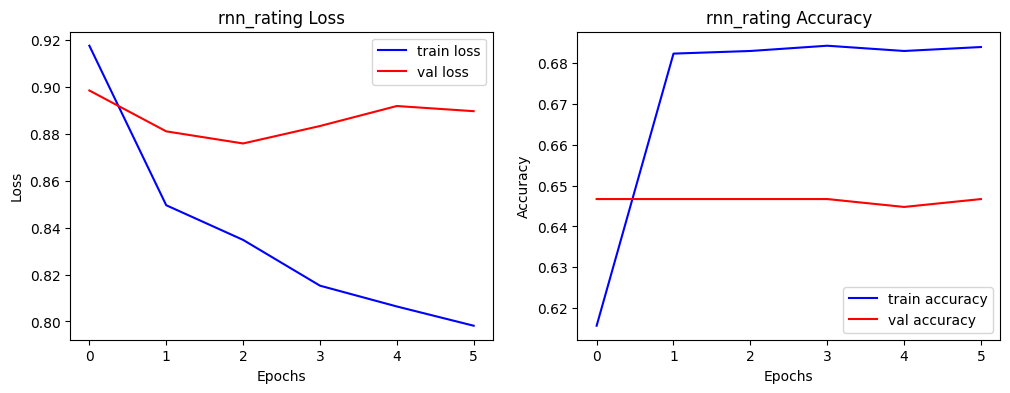

rnn_rating Metrics:
Accuracy: 0.6467181467181468
Balanced Accuracy: 0.3333333333333333
F1 Score: 0.507973221923984
ROC AUC: 0.5287811771020416
Precision: 0.4182443612945544
Recall: 0.6467181467181468
Confusion Matrix:
[[  0   0 125]
 [  0   0 241]
 [  0   0 670]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


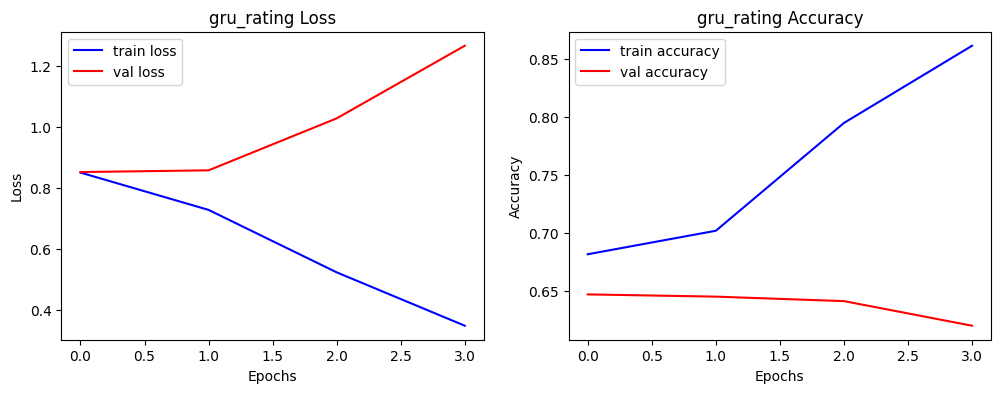

gru_rating Metrics:
Accuracy: 0.6467181467181468
Balanced Accuracy: 0.3333333333333333
F1 Score: 0.507973221923984
ROC AUC: 0.6003745174542227
Precision: 0.4182443612945544
Recall: 0.6467181467181468
Confusion Matrix:
[[  0   0 125]
 [  0   0 241]
 [  0   0 670]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


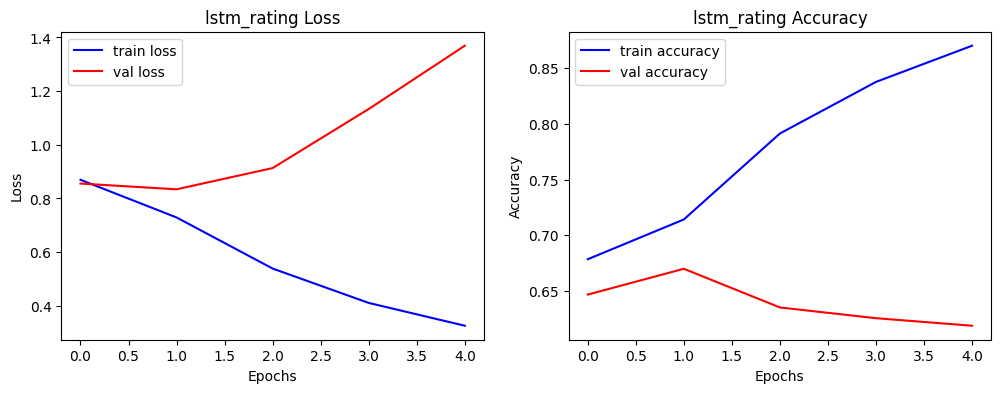

lstm_rating Metrics:
Accuracy: 0.6698841698841699
Balanced Accuracy: 0.41258025226564277
F1 Score: 0.6038600668418884
ROC AUC: 0.6266820420717987
Precision: 0.5698435516851073
Recall: 0.6698841698841699
Confusion Matrix:
[[  0  19 106]
 [  0  76 165]
 [  0  52 618]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


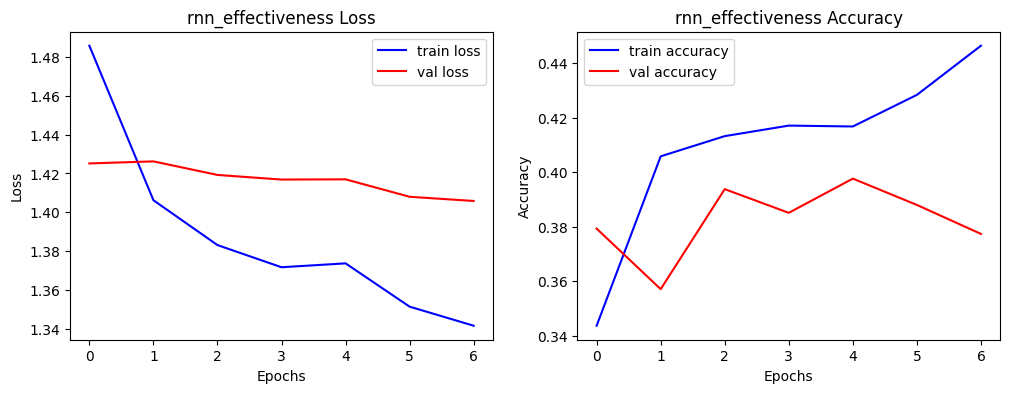

rnn_effectiveness Metrics:
Accuracy: 0.37741312741312744
Balanced Accuracy: 0.19946315045914764
F1 Score: 0.28009178367292753
ROC AUC: 0.5466641596252071
Precision: 0.24385719399506164
Recall: 0.37741312741312744
Confusion Matrix:
[[ 58 252   0   0   0]
 [ 78 333   0   0   0]
 [ 17  65   0   0   0]
 [ 15  61   0   0   0]
 [ 36 121   0   0   0]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


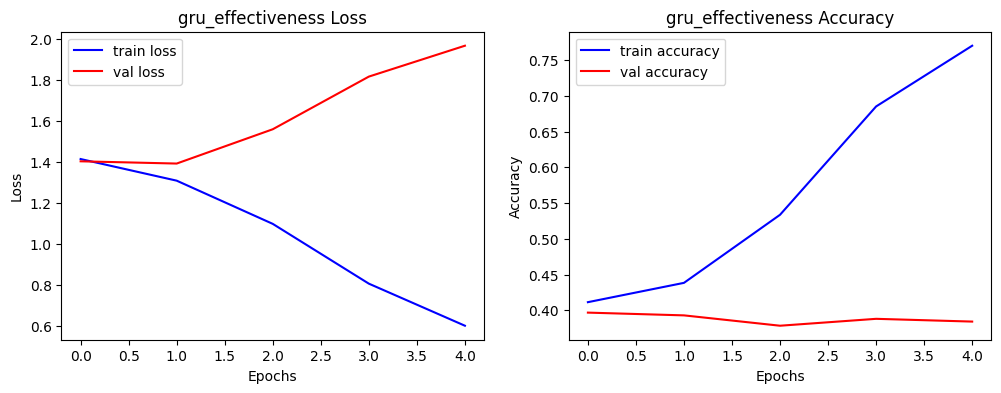

gru_effectiveness Metrics:
Accuracy: 0.39285714285714285
Balanced Accuracy: 0.21134593430763013
F1 Score: 0.280154030984612
ROC AUC: 0.5776489409023347
Precision: 0.2924115556586253
Recall: 0.39285714285714285
Confusion Matrix:
[[ 32 274   0   0   4]
 [ 33 369   4   0   5]
 [ 11  62   3   0   6]
 [ 13  60   3   0   0]
 [ 22 128   4   0   3]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


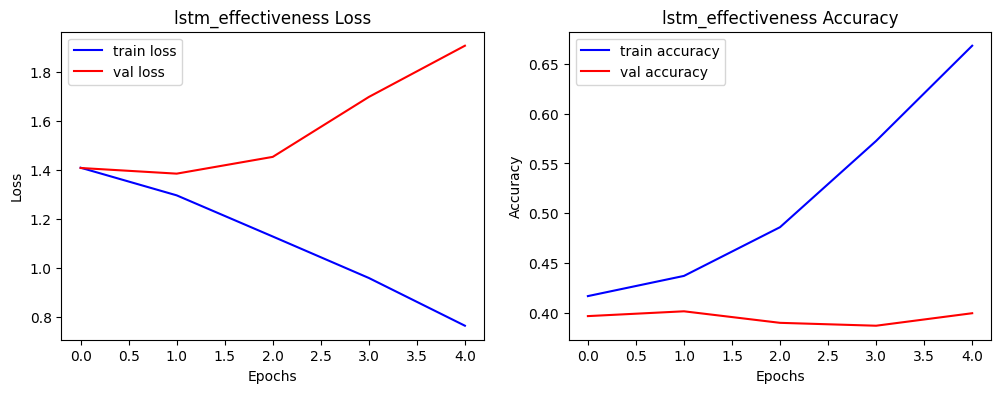

lstm_effectiveness Metrics:
Accuracy: 0.4015444015444015
Balanced Accuracy: 0.22332552111310705
F1 Score: 0.2783554563239091
ROC AUC: 0.5829667723517471
Precision: 0.31441558901529115
Recall: 0.4015444015444015
Confusion Matrix:
[[ 13 281   5   0  11]
 [ 12 385   4   0  10]
 [  7  58   4   0  13]
 [  3  63   6   0   4]
 [  6 130   7   0  14]]


In [31]:
results = {}
for rnn_mod, model in models.items():
    if 'rating' in rnn_mod:
        results[rnn_mod] = evaluate_model(model, X_test_pad, y_test_rating)
    else:
        results[rnn_mod] = evaluate_model(model, X_test_pad, y_test_effectiveness)

    plot_learning_curves(history[rnn_mod], rnn_mod)
    metrics = results[rnn_mod]
    print(f'{rnn_mod} Metrics:')
    print(f'Accuracy: {metrics[0]}')
    print(f'Balanced Accuracy: {metrics[1]}')
    print(f'F1 Score: {metrics[2]}')
    print(f'ROC AUC: {metrics[3]}')
    print(f'Precision: {metrics[4]}')
    print(f'Recall: {metrics[5]}')
    print(f'Confusion Matrix:\n{metrics[6]}')